In [2]:
# Importing dependecies
import pandas as pd
import json
import requests
import prettytable
from config import api_key
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Dictionary of series ID 
category_dict = {
    'CXUFOODAWAYLB1101M': 'Food Away',
    'CXUAPPARELLB1101M': 'Apparel',
    'CXUENTRTAINLB1101M': 'Entertainment',
    'CXUCASHCONTLB1101M': 'Cash Contribution',
    'CXUALCBEVGLB1101M': 'Alcohol Beverages',
    'CXUEDUCATNLB1101M': 'Education',
    'CXUPERSCARELB1101M': 'Personal Care',
    'CXUTOBACCOLB1101M': 'Tobacco'
}

# List of series IDs
category_list = list(category_dict.keys())

In [4]:
# Load the json response for the API queries
def json_df(dictionary):
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid": list(dictionary.keys()),"startyear":"2005", "endyear":"2018","registrationkey":api_key})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)

    try:
        df = pd.DataFrame()

        # Loops through the json response to create a DataFrame
        for series in json_data['Results']['series']:
            # Create an initial DataFrame with column of Series IDs and dictionary of data
            df_initial = pd.DataFrame(series)
            series_col = df_initial['seriesID'][0]

            # Loops through the length of the initial DF to split up its second column
            for i in range(0, len(df_initial) - 1):
                df_row = pd.DataFrame(df_initial['data'][i])
                df_row['seriesID'] = series_col
                if 'code' not in str(df_row['footnotes']): 
                    df_row['footnotes'] = ''
                else:
                    df_row['footnotes'] = str(df_row['footnotes']).split("'code': '",1)[1][:1]
                df = df.append(df_row, ignore_index=True)

    except:
        json_data['status'] == 'REQUEST_NOT_PROCESSED'
        print('BLS API has given the following Response:', json_data['status'])
        print('Reason:', json_data['message'])
    return df

In [24]:
def get_total(df):
    # Initialize variables
    total = []
    dict_list = []
    i = 0
    
    # Convert the value column to float - a numeric data type will be needed to visualize the data
    df['value'] = df['value'].astype(float)
    
    series_set = set(df["seriesID"])
    for e in series_set:
        dict_list.append(e)
    
    dict_list = sorted(dict_list)
    
    # Loop through series list to create a list of the totals of each spending category
    for key in dict_list:
        # Append a value to a list to record the spending for each category
        total.append(int(df.groupby('seriesID')['value'].sum()[key]))

        # Counter
        i = i + 1
    return total

In [6]:
df_category = json_df(category_dict)

In [7]:
total = get_total(df_category)

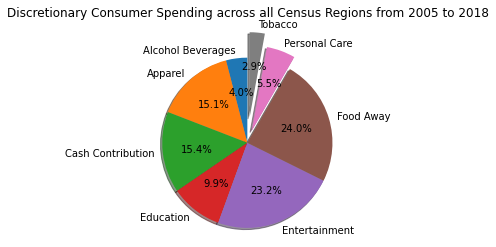

In [8]:
# Labels of the categories
labels = sorted(list(category_dict.values()))

# Explode the two smallest expenses (i.e Tobacco and Personal Care)
explode = (0, 0, 0, 0, 0, 0, .15, .3)  

# Initialize figure and axis
fig1, ax1 = plt.subplots()

# Create pie chart of the breakdown of discretionary spending
ax1.pie(total, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Discretionary Consumer Spending across all Census Regions from 2005 to 2018')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [9]:
df_category = df_category.sort_values(['seriesID','year'], ascending = True).reset_index(drop=True)
df_category

,year,period,periodName,latest,value,footnotes,seriesID
0,2006,A01,Annual,NaN,497.0,,CXUALCBEVGLB1101M
1,2007,A01,Annual,NaN,457.0,,CXUALCBEVGLB1101M
2,2008,A01,Annual,NaN,444.0,,CXUALCBEVGLB1101M
3,2009,A01,Annual,NaN,435.0,,CXUALCBEVGLB1101M
4,2010,A01,Annual,NaN,412.0,,CXUALCBEVGLB1101M
...,...,...,...,...,...,...,...
99,2014,A01,Annual,NaN,319.0,,CXUTOBACCOLB1101M
100,2015,A01,Annual,NaN,349.0,,CXUTOBACCOLB1101M
101,2016,A01,Annual,NaN,337.0,,CXUTOBACCOLB1101M
102,2017,A01,Annual,NaN,332.0,,CXUTOBACCOLB1101M


In [10]:
# Get percent change over the years, grouped by series ID
df_category['pct_decimal'] = df_category.groupby(['seriesID'])['value'].pct_change()
df_category['percent_change'] = df_category['pct_decimal'].multiply(100)
df_category

,year,period,periodName,latest,value,footnotes,seriesID,pct_decimal,percent_change
0,2006,A01,Annual,NaN,497.0,,CXUALCBEVGLB1101M,NaN,NaN
1,2007,A01,Annual,NaN,457.0,,CXUALCBEVGLB1101M,-0.080483,-8.048290
2,2008,A01,Annual,NaN,444.0,,CXUALCBEVGLB1101M,-0.028446,-2.844639
3,2009,A01,Annual,NaN,435.0,,CXUALCBEVGLB1101M,-0.020270,-2.027027
4,2010,A01,Annual,NaN,412.0,,CXUALCBEVGLB1101M,-0.052874,-5.287356
...,...,...,...,...,...,...,...,...,...
99,2014,A01,Annual,NaN,319.0,,CXUTOBACCOLB1101M,-0.033333,-3.333333
100,2015,A01,Annual,NaN,349.0,,CXUTOBACCOLB1101M,0.094044,9.404389
101,2016,A01,Annual,NaN,337.0,,CXUTOBACCOLB1101M,-0.034384,-3.438395
102,2017,A01,Annual,NaN,332.0,,CXUTOBACCOLB1101M,-0.014837,-1.483680


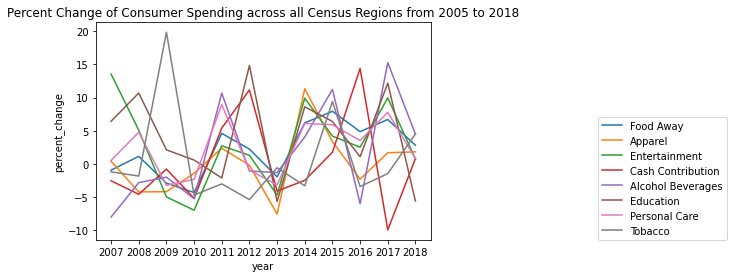

In [11]:
# Produce line chart of percentage change of spend on each item over time
labels = (list(category_dict.values()))
i=0
fig,ax = plt.subplots()
for seriesID in list(category_dict.keys()):
    ax.plot(df_category[df_category.seriesID==seriesID].year,
            df_category[df_category.seriesID==seriesID].percent_change,
            label=labels[i])
    i=i+1
plt.title('Percent Change of Consumer Spending across all Census Regions from 2005 to 2018')
ax.set_xlabel("year")
ax.set_ylabel("percent_change")
plt.legend(loc=(1.5,0))

In [29]:
age25_dict = {
    
#AGE UNDER 25 LB0402M
    #STUFF FOR DISCRECTIONARY (FREELY SPENT)
    'CXUFOODAWAYLB0402M': 'FoodAway_AllRegions',
    'CXUAPPARELLB0402M': 'Apparel_AllRegions',
    'CXUENTRTAINLB0402M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB0402M': 'CashCont_AllRegions',
    'CXUALCBEVGLB0402M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB0402M': 'Edu_AllRegions',
    'CXUPERSCARELB0402M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB0402M': 'Tobacco_AllRegions',
    #STUFF FOR DISPOSABLE (BILLS TO PAY)
    'CXUFOODHOMELB0402M': 'FOOD HOME',
    'CXUHEALTHLB0402M': 'HEALTH',
    'CXUHOUSINGLB0402M': 'HOUSING',
    'CXUTRANSLB0402M': 'TRANSPORT',  
}

df_age25 = json_df(age25_dict)
df_age25

,year,period,periodName,latest,value,footnotes,seriesID
0,2018,A01,Annual,true,2336,,CXUFOODAWAYLB0402M
1,2017,A01,Annual,NaN,2362,,CXUFOODAWAYLB0402M
2,2016,A01,Annual,NaN,2250,,CXUFOODAWAYLB0402M
3,2015,A01,Annual,NaN,2347,,CXUFOODAWAYLB0402M
4,2014,A01,Annual,NaN,1926,,CXUFOODAWAYLB0402M
...,...,...,...,...,...,...,...
151,2010,A01,Annual,NaN,4692,,CXUTRANSLB0402M
152,2009,A01,Annual,NaN,5334,,CXUTRANSLB0402M
153,2008,A01,Annual,NaN,5464,,CXUTRANSLB0402M
154,2007,A01,Annual,NaN,5708,,CXUTRANSLB0402M


In [30]:
age2534_dict = {

#Age 25-34 LB0403M
    #STUFF FOR DISCRECTIONARY (FREELY SPENT)
    'CXUFOODAWAYLB0403M': 'FoodAway_AllRegions',
    'CXUAPPARELLB0403M': 'Apparel_AllRegions',
    'CXUENTRTAINLB0403M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB0403M': 'CashCont_AllRegions',
    'CXUALCBEVGLB0403M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB0403M': 'Edu_AllRegions',
    'CXUPERSCARELB0403M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB0403M': 'Tobacco_AllRegions',
    #STUFF FOR DISPOSABLE (BILLS TO PAY)
    'CXUFOODHOMELB0403M': 'FOOD HOME',
    'CXUHEALTHLB0403M': 'HEALTH',
    'CXUHOUSINGLB0403M': 'HOUSING',
    'CXUTRANSLB0403M': 'TRANSPORT',   
}

df_age2534 = json_df(age2534_dict)
df_age2534

,year,period,periodName,latest,value,footnotes,seriesID
0,2018,A01,Annual,true,3450,,CXUFOODAWAYLB0403M
1,2017,A01,Annual,NaN,3416,,CXUFOODAWAYLB0403M
2,2016,A01,Annual,NaN,3165,,CXUFOODAWAYLB0403M
3,2015,A01,Annual,NaN,3097,,CXUFOODAWAYLB0403M
4,2014,A01,Annual,NaN,2921,,CXUFOODAWAYLB0403M
...,...,...,...,...,...,...,...
151,2010,A01,Annual,NaN,8231,,CXUTRANSLB0403M
152,2009,A01,Annual,NaN,7671,,CXUTRANSLB0403M
153,2008,A01,Annual,NaN,8699,,CXUTRANSLB0403M
154,2007,A01,Annual,NaN,9065,,CXUTRANSLB0403M


In [31]:
age3544_dict = {
    
#Age 35-44 LB0404M
    #STUFF FOR DISCRECTIONARY (FREELY SPENT)
    'CXUFOODAWAYLB0404M': 'FoodAway_AllRegions',
    'CXUAPPARELLB0404M': 'Apparel_AllRegions',
    'CXUENTRTAINLB0404M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB0404M': 'CashCont_AllRegions',
    'CXUALCBEVGLB0404M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB0404M': 'Edu_AllRegions',
    'CXUPERSCARELB0404M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB0404M': 'Tobacco_AllRegions',
    #STUFF FOR DISPOSABLE (BILLS TO PAY)
    'CXUFOODHOMELB0404M': 'FOOD HOME',
    'CXUHEALTHLB0404M': 'HEALTH',
    'CXUHOUSINGLB0404M': 'HOUSING',
    'CXUTRANSLB0404M': 'TRANSPORT',   
}

df_age3544 = json_df(age3544_dict)
df_age3544

,year,period,periodName,latest,value,footnotes,seriesID
0,2018,A01,Annual,true,4395,,CXUFOODAWAYLB0404M
1,2017,A01,Annual,NaN,4249,,CXUFOODAWAYLB0404M
2,2016,A01,Annual,NaN,3975,,CXUFOODAWAYLB0404M
3,2015,A01,Annual,NaN,3900,,CXUFOODAWAYLB0404M
4,2014,A01,Annual,NaN,3388,,CXUFOODAWAYLB0404M
...,...,...,...,...,...,...,...
151,2010,A01,Annual,NaN,8763,,CXUTRANSLB0404M
152,2009,A01,Annual,NaN,8364,,CXUTRANSLB0404M
153,2008,A01,Annual,NaN,9797,,CXUTRANSLB0404M
154,2007,A01,Annual,NaN,10558,,CXUTRANSLB0404M


In [32]:
age4554_dict = {
    
#Age 45-54 LB0405M
    #STUFF FOR DISCRECTIONARY (FREELY SPENT)
    'CXUFOODAWAYLB0405M': 'FoodAway_AllRegions',
    'CXUAPPARELLB0405M': 'Apparel_AllRegions',
    'CXUENTRTAINLB0405M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB0405M': 'CashCont_AllRegions',
    'CXUALCBEVGLB0405M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB0405M': 'Edu_AllRegions',
    'CXUPERSCARELB0405M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB0405M': 'Tobacco_AllRegions',
    #STUFF FOR DISPOSABLE (BILLS TO PAY)
    'CXUFOODHOMELB0405M': 'FOOD HOME',
    'CXUHEALTHLB0405M': 'HEALTH',
    'CXUHOUSINGLB0405M': 'HOUSING',
    'CXUTRANSLB0405M': 'TRANSPORT',   
}

df_age4554 = json_df(age4554_dict)
df_age4554

,year,period,periodName,latest,value,footnotes,seriesID
0,2018,A01,Annual,true,4397,,CXUFOODAWAYLB0405M
1,2017,A01,Annual,NaN,4157,,CXUFOODAWAYLB0405M
2,2016,A01,Annual,NaN,3979,,CXUFOODAWAYLB0405M
3,2015,A01,Annual,NaN,3693,,CXUFOODAWAYLB0405M
4,2014,A01,Annual,NaN,3394,,CXUFOODAWAYLB0405M
...,...,...,...,...,...,...,...
151,2010,A01,Annual,NaN,9255,,CXUTRANSLB0405M
152,2009,A01,Annual,NaN,9409,,CXUTRANSLB0405M
153,2008,A01,Annual,NaN,10691,,CXUTRANSLB0405M
154,2007,A01,Annual,NaN,9943,,CXUTRANSLB0405M


In [33]:
age5564_dict = {
    
#Age 55-64 LB0406M
    #STUFF FOR DISCRECTIONARY (FREELY SPENT)
    'CXUFOODAWAYLB0406M': 'FoodAway_AllRegions',
    'CXUAPPARELLB0406M': 'Apparel_AllRegions',
    'CXUENTRTAINLB0406M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB0406M': 'CashCont_AllRegions',
    'CXUALCBEVGLB0406M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB0406M': 'Edu_AllRegions',
    'CXUPERSCARELB0406M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB0406MM': 'Tobacco_AllRegions',
    #STUFF FOR DISPOSABLE (BILLS TO PAY)
    'CXUFOODHOMELB0406MM': 'FOOD HOME',
    'CXUHEALTHLB0406MM': 'HEALTH',
    'CXUHOUSINGLB0406MM': 'HOUSING',
    'CXUTRANSLB0406MM': 'TRANSPORT',  
}

df_age5564 = json_df(age5564_dict)
df_age5564

BLS API has given the following Response: REQUEST_SUCCEEDED
Reason: ['Series does not exist for Series CXUFOODHOMELB0406MM', 'Series does not exist for Series CXUHEALTHLB0406MM', 'Series does not exist for Series CXUHOUSINGLB0406MM', 'Series does not exist for Series CXUTOBACCOLB0406MM', 'Series does not exist for Series CXUTRANSLB0406MM']


,year,period,periodName,latest,value,footnotes,seriesID
0,2018,A01,Annual,true,3268,,CXUFOODAWAYLB0406M
1,2017,A01,Annual,NaN,3229,,CXUFOODAWAYLB0406M
2,2016,A01,Annual,NaN,3083,,CXUFOODAWAYLB0406M
3,2015,A01,Annual,NaN,2792,,CXUFOODAWAYLB0406M
4,2014,A01,Annual,NaN,2691,,CXUFOODAWAYLB0406M
...,...,...,...,...,...,...,...
86,2010,A01,Annual,NaN,599,,CXUPERSCARELB0406M
87,2009,A01,Annual,NaN,617,,CXUPERSCARELB0406M
88,2008,A01,Annual,NaN,630,,CXUPERSCARELB0406M
89,2007,A01,Annual,NaN,632,,CXUPERSCARELB0406M


In [34]:
age65_dict = {
    
#Age Over 65 LB0407
    #STUFF FOR DISCRECTIONARY (FREELY SPENT)
    'CXUFOODAWAYLB0407M': 'FoodAway_AllRegions',
    'CXUAPPARELLB0407M': 'Apparel_AllRegions',
    'CXUENTRTAINLB0407M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB0407M': 'CashCont_AllRegions',
    'CXUALCBEVGLB0407M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB0407M': 'Edu_AllRegions',
    'CXUPERSCARELB0407M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB0407M': 'Tobacco_AllRegions',
    #STUFF FOR DISPOSABLE (BILLS TO PAY)
    'CXUFOODHOMELB0407M': 'FOOD HOME',
    'CXUHEALTHLB0407M': 'HEALTH',
    'CXUHOUSINGLB0407M': 'HOUSING',
    'CXUTRANSLB0407M': 'TRANSPORT',   
}

df_age65 = json_df(age65_dict)
df_age65

,year,period,periodName,latest,value,footnotes,seriesID
0,2018,A01,Annual,true,2598,,CXUFOODAWAYLB0407M
1,2017,A01,Annual,NaN,2511,,CXUFOODAWAYLB0407M
2,2016,A01,Annual,NaN,2232,,CXUFOODAWAYLB0407M
3,2015,A01,Annual,NaN,2108,,CXUFOODAWAYLB0407M
4,2014,A01,Annual,NaN,2064,,CXUFOODAWAYLB0407M
...,...,...,...,...,...,...,...
151,2010,A01,Annual,NaN,5242,,CXUTRANSLB0407M
152,2009,A01,Annual,NaN,5409,,CXUTRANSLB0407M
153,2008,A01,Annual,NaN,5620,,CXUTRANSLB0407M
154,2007,A01,Annual,NaN,5785,,CXUTRANSLB0407M


In [50]:
#Set list for each Age Group to store totals for each category (alphabetized)
print("Order of Totals")
print("Alcohol, Apparel, CashCont, Education, Entertainment, FoodAway, FoodHome, Health, House, PersCare, Tobacco, Transport")
print ("")

AgeUnder25 = get_total(df_age25)
print("AgeUnder25")
print(AgeUnder25)
print("")

Age25to34 = get_total(df_age2534)
print("Age25to34")
print(Age25to34)
print("")

Age35to44 = get_total(df_age3544)
print("Age35to44")
print(Age35to44)
print("")

Age45to54 = get_total(df_age4554)
print("Age45to54")
print(Age45to54)
print("")

Age55to64 = get_total(df_age5564)
print("Age55to64")
print(Age55to64)
print("Alcohol, Apparel, CashCont, Education, Entertainment, FoodAway, PersCare. DATA NOT FOUND")
print("")

Age64plus = get_total(df_age65)
print("Age65plus")
print(Age64plus)
print("")

Order of Totals
Alcohol, Apparel, CashCont, Education, Entertainment, FoodAway, FoodHome, Health, House, PersCare, Tobacco, Transport

AgeUnder25
[4654, 17669, 5793, 27749, 17727, 26746, 30850, 12443, 136677, 4836, 3413, 75131]

Age25to34
[6999, 25780, 13199, 12545, 31887, 38273, 46157, 29615, 231129, 7426, 4325, 117711]

Age35to44
[6952, 29915, 20530, 13129, 43257, 45920, 60084, 41746, 276977, 9749, 4745, 132477]

Age45to54
[6982, 28108, 27481, 29278, 42955, 44716, 59448, 50014, 262643, 9961, 5724, 137619]

Age55to64
[6624, 22071, 29545, 14275, 38840, 35997, 8759]
Alcohol, Apparel, CashCont, Education, Entertainment, FoodAway, PersCare. DATA NOT FOUND

Age65plus
[4356, 13898, 31218, 3541, 28299, 25184, 42912, 69233, 184932, 7430, 2579, 82148]



list